In [1]:
from bitmex_websocket import BitMEXWebsocket
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ws = BitMEXWebsocket(endpoint="https://testnet.bitmex.com/api/v1", symbol='XBTUSD', api_key="9AyrVqTa4HROjUq3FZfIK-p_", api_secret="EInjEO0WPdasTM4ne7RHN5Q8aBQ-O6HwhFnY3olm7_LKvSNa")

In [3]:
df = pd.DataFrame(ws.market_depth())

In [4]:
df.head()

,symbol,id,side,size,price
0,XBTUSD,15500000000,Sell,1003,1000000.0
1,XBTUSD,15500000100,Sell,100001,999999.0
2,XBTUSD,15502119900,Sell,5000,978801.0
3,XBTUSD,15504648350,Sell,2191000,953516.5
4,XBTUSD,15515440800,Sell,300,845592.0


In [5]:
df.shape

(2007, 5)

In [6]:
def request_history(symbol, interval_mins=60, load_periods=500):
    from time import time
    import requests
    import numpy as np
    import pandas as pd
    # TODO Allow user to input start and end date.
    # Do calculation to caculate num of load_periods needed for date range.
    
    end_t = int(time()) + 120*interval_mins
    end_t -= end_t % (60*interval_mins)
    start_t = end_t - load_periods*60*interval_mins

    baseurl = 'https://www.bitmex.com/api'
    url = baseurl + f'/udf/history?symbol={symbol}&resolution={interval_mins}&from={start_t}&to={end_t}'
    req = requests.get(url).json()

    df = pd.DataFrame(req)
    # rename headers to something more explicitive
    df.rename({'t': 'date', 'c': 'close', 'o': 'open', 'h': 'high', 'l': 'low', 'v': 'volume'}, axis=1, inplace=True)
    # convert date column from unix time to datetime object
    df['date'] = pd.to_datetime(df['date'], origin='unix', unit='s')
    # add colors to customize volume bar chart
    df['color'] = np.where(df['close'] > df['open'], 'green', 'red')
    # convert index to datetime object
    df.index = df['date']

    return df

In [7]:
current_price = request_history(symbol='XBTUSD', interval_mins=1, load_periods=1)['close'].iloc[0]
print(current_price)

9328.5


In [8]:
lower_bound = current_price * 0.99
upper_bound = current_price * 1.01

In [9]:
df = df.loc[(df.price > lower_bound) & (df.price < upper_bound)]

In [10]:
df.shape

(285, 5)

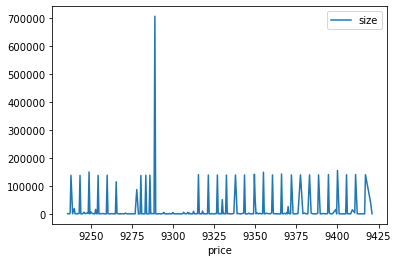

In [11]:
df.plot(kind='line', x='price', y='size')

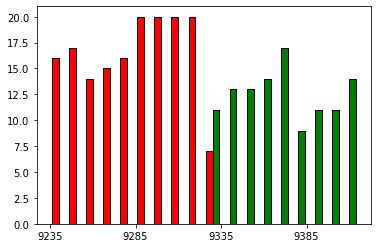

In [12]:
bins=[n for n in range(int(lower_bound), int(upper_bound), 10)]

lower_df = df.loc[df.price < current_price].price
upper_df = df.loc[df.price > current_price].price

plt.hist([lower_df, upper_df], bins=bins, edgecolor="k", color=['red', 'green'])
plt.xticks(bins[::5])  # display every 5th tick on x-axis
plt.show()

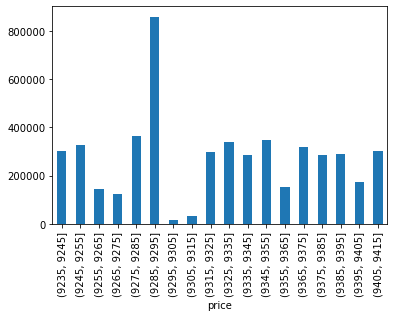

In [13]:
groups = df.groupby([pd.cut(df.price, bins)])['size'].sum()
groups.plot(kind='bar')